# Part 3: Ranking

In [1]:
import pandas as pd
import re
import json
from array import array

import numpy as np
import math
from numpy import linalg as la

from collections import defaultdict
import collections

import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

C:\Users\mirei\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mirei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Open txt and save it as a pandas dataframe
with open('dataset_tweets_WHO.txt') as f:
    json_data = json.load(f)
    
data = pd.DataFrame(json_data).transpose()

In [3]:
data = pd.concat([data.drop(['entities'], axis=1), data['entities'].apply(pd.Series)], axis=1)

In [4]:
data = pd.concat([data.drop(['user'], axis=1), data['user'].apply(pd.Series)], axis=1)

### Clean tweets

In [5]:
#function to process the tweets
def build_terms(line):
    """
    Preprocess the tweets removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    
    ## START CODE
    line= str.lower(line) # Transform in lowercase
    line = re.sub('[^\w\s]','', line) # removing punctuation
    line= line.split() # Tokenization
    line= [l for l in line if l not in stop_words] # remove stopwords
    line= [stemmer.stem(word) for word in line] # stemming
    

    ## END CODE
    return line

### 1.a) TF-IDF ranking

In [6]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of tweets
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    page_id = 0
    for line in lines:  # Remember, lines contain all documents
        terms = build_terms(''.join(line)) 
        title_index[page_id]=terms  
        

        ## ===============================================================        
        ## create the index for the *current page* and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = df[term] + 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)
            
        page_id += 1

    return index, tf, df, idf, title_index

In [7]:
lines = list(data['full_text'])
num_documents = len(lines)
index, tf, df, idf, title_index = create_index_tfidf(lines, num_documents)

Here we will look at the tf of all the words used in the different keys and sort them in a descending order.

In [8]:
#average  of tf for each word
avgs = []

for key in tf.keys():
    av = np.mean(tf[key])
    avgs.append(av)
    
avgs_sorted = sorted(range(len(avgs)), key=lambda k:avgs[k])

#### Apply TF-IDF ranking

In [9]:
def rank_documents_tf_idf(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [10]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms ahd their scores
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = set()
    
    for term in query:        
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            if len(docs) == 0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
                
            
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents_tf_idf(query, docs, index, idf, tf, title_index)
    return ranked_docs, doc_scores

In [11]:
query1 = 'vaccine covid19' 
query2 = 'color pandemic' 
query3 = 'vaccine pandemic'
query4 = 'color risk' 
query5 = 'risk covid19'

queries = [query1, query2, query3, query4, query5]

top = 20

ranked_docs_list = []
scores_list = []

for query in queries:

    ranked_docs, doc_scores = search_tf_idf(query, index)
    ranked_docs_list.append(ranked_docs)
    scores_list.append(doc_scores)

    print('There are', len(ranked_docs), 'results for the search query:', query)

There are 284 results for the search query: vaccine covid19
There are 234 results for the search query: color pandemic
There are 50 results for the search query: vaccine pandemic
There are 111 results for the search query: color risk
There are 47 results for the search query: risk covid19


In [12]:
for i in range(len(queries)):
    print(queries[i])
    ranked_docs = ranked_docs_list[i]
    for doc in ranked_docs:
        print(data.iloc[doc][['full_text', 'name', 'created_at', 'hashtags', 'favorite_count', 'retweet_count', 'url']])
        print("------------------------------------------------")

vaccine covid19
full_text         The mRNA #COVID19 vaccines are as safe as othe...
name                                World Health Organization (WHO)
created_at                           Fri Jul 23 08:32:05 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'COVID19', 'indices': [9, 17]}]
favorite_count                                                  419
retweet_count                                                   240
url                                         https://t.co/wVulKuROWG
Name: 1833, dtype: object
------------------------------------------------
full_text         RT @WHOWPRO: Encourage your loved ones to get ...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 15:37:03 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [65, 73]}]
favorite_count           

Name: 510, dtype: object
------------------------------------------------
full_text         What do we know about the #COVID19 Delta varia...
name                                World Health Organization (WHO)
created_at                           Mon Jul 05 21:00:08 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [26, 34]}, {'t...
favorite_count                                                  275
retweet_count                                                   167
url                                         https://t.co/wVulKuROWG
Name: 2153, dtype: object
------------------------------------------------
full_text         @DrTedros "Currently, data shows us that vacci...
name                                World Health Organization (WHO)
created_at                           Mon Jul 12 14:45:54 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID1

Name: 915, dtype: object
------------------------------------------------
full_text         #COVAX urges all government authorities to rec...
name                                World Health Organization (WHO)
created_at                           Thu Jul 01 12:01:16 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVAX', 'indices': [0, 6]}, {'text'...
favorite_count                                                  470
retweet_count                                                   195
url                                         https://t.co/wVulKuROWG
Name: 2244, dtype: object
------------------------------------------------
full_text         @DrTedros "Variants are currently winning the ...
name                                World Health Organization (WHO)
created_at                           Wed Jul 07 13:21:56 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID1

Name: 614, dtype: object
------------------------------------------------
full_text         "In particularly, I urge those companies – Bio...
name                                World Health Organization (WHO)
created_at                           Fri Jul 02 13:05:19 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [146, 154]}]
favorite_count                                                  119
retweet_count                                                    59
url                                         https://t.co/wVulKuROWG
Name: 2191, dtype: object
------------------------------------------------
full_text         "Collectively we also made several asks to the...
name                                World Health Organization (WHO)
created_at                           Fri Jul 02 13:07:43 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                [{'text': '

Name: 167, dtype: object
------------------------------------------------
full_text         Many countries around the 🌎🌍🌏 still face steep...
name                                World Health Organization (WHO)
created_at                           Sun Oct 03 19:48:00 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [60, 68]}, {'t...
favorite_count                                                  122
retweet_count                                                    49
url                                         https://t.co/wVulKuROWG
Name: 251, dtype: object
------------------------------------------------
full_text         RT @DrTedros: We are calling on #G20 countries...
name                                World Health Organization (WHO)
created_at                           Wed Jun 30 22:21:44 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'G20', '

Name: 2124, dtype: object
------------------------------------------------
full_text         RT @WHOAFRO: Don't miss tomorrow's @WHOAFRO pr...
name                                World Health Organization (WHO)
created_at                           Wed Jul 14 14:07:27 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [62, 70]}, {'t...
favorite_count                                                    0
retweet_count                                                    35
url                                         https://t.co/wVulKuROWG
Name: 2011, dtype: object
------------------------------------------------
full_text         #VaccinEquity is the springboard that allows u...
name                                World Health Organization (WHO)
created_at                           Sat Jul 31 14:41:09 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'Vacci

Name: 1928, dtype: object
------------------------------------------------
full_text         @Olympics @DrTedros "The global failure to sha...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 00:28:09 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [49, 57]}, {'t...
favorite_count                                                   81
retweet_count                                                    38
url                                         https://t.co/wVulKuROWG
Name: 1924, dtype: object
------------------------------------------------
full_text         @DrTedros "So far, more than 4 billion #COVID1...
name                                World Health Organization (WHO)
created_at                           Wed Aug 04 13:16:37 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text':

Name: 846, dtype: object
------------------------------------------------
full_text         Global leaders attending the #COVIDSummit comm...
name                                World Health Organization (WHO)
created_at                           Fri Sep 24 08:17:53 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVIDSummit', 'indices': [29, 41]},...
favorite_count                                                  209
retweet_count                                                    67
url                                         https://t.co/wVulKuROWG
Name: 533, dtype: object
------------------------------------------------
full_text         @DrTedros @antonioguterres "As you know, earli...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:43:00 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19

full_text         @Olympics @DrTedros @Tokyo2020 @Paralympics @g...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 01:05:19 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [74, 82]}, {'t...
favorite_count                                                   47
retweet_count                                                    27
url                                         https://t.co/wVulKuROWG
Name: 1896, dtype: object
------------------------------------------------
full_text         @Olympics @DrTedros @Tokyo2020 @Paralympics @g...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 01:17:16 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'Tokyo2020', 'indices': [79, 89]}, {...
favorite_count                           

full_text         The #COVID19 situation globally is very danger...
name                                World Health Organization (WHO)
created_at                           Thu Jul 08 20:17:10 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'COVID19', 'indices': [4, 12]}]
favorite_count                                                 6016
retweet_count                                                  4219
url                                         https://t.co/wVulKuROWG
Name: 2086, dtype: object
------------------------------------------------
full_text         @DrTedros @gavi @CEPIvaccines @UNICEF @_Africa...
name                                World Health Organization (WHO)
created_at                           Tue Sep 14 14:23:24 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [182, 190]}, {...
favorite_count                           

full_text         RT @DrTedros: Today is #WorldMentalHealthDay! ...
name                                World Health Organization (WHO)
created_at                           Sun Oct 10 15:45:49 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'WorldMentalHealthDay', 'indices': [...
favorite_count                                                    0
retweet_count                                                    85
url                                         https://t.co/wVulKuROWG
Name: 83, dtype: object
------------------------------------------------
full_text         RT @DrTedros: Minister Tamura &amp; I spoke ab...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 21:48:46 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags            [{'text': 'VaccinEquity', 'indices': [68, 81]}]
favorite_count                             

full_text         RT @pahowho: “Even as we work to end the pande...
name                                World Health Organization (WHO)
created_at                           Mon Sep 20 18:52:45 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                                                    0
retweet_count                                                    29
url                                         https://t.co/wVulKuROWG
Name: 639, dtype: object
------------------------------------------------
full_text         Contraception and family planning information ...
name                                World Health Organization (WHO)
created_at                           Sun Sep 26 07:52:32 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [142, 150]}, {...
favorite_count                            

Name: 300, dtype: object
------------------------------------------------
full_text         We can't put out a fire 🔥 without fire engines...
name                                World Health Organization (WHO)
created_at                           Fri Oct 08 17:38:19 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [132, 140]}]
favorite_count                                                  118
retweet_count                                                    22
url                                         https://t.co/wVulKuROWG
Name: 141, dtype: object
------------------------------------------------
full_text         "Many Small Island Developing States have succ...
name                                World Health Organization (WHO)
created_at                           Fri Jul 02 12:51:16 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                [{'text': 'C

Name: 140, dtype: object
------------------------------------------------
full_text         During the #COVID19 pandemic, online and ICT-f...
name                                World Health Organization (WHO)
created_at                           Mon Oct 11 15:26:21 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [11, 19]}, {'t...
favorite_count                                                  201
retweet_count                                                    73
url                                         https://t.co/wVulKuROWG
Name: 31, dtype: object
------------------------------------------------
full_text         "By the end of this September, we’re calling o...
name                                World Health Organization (WHO)
created_at                           Fri Jul 02 13:01:14 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COV

full_text         @DrTedros @jensspahn @ACTAccelerator "So thank...
name                                World Health Organization (WHO)
created_at                           Thu Jul 15 12:29:31 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [138, 146]}]
favorite_count                                                   88
retweet_count                                                    25
url                                         https://t.co/wVulKuROWG
Name: 1973, dtype: object
------------------------------------------------
full_text         @Olympics @DrTedros @Tokyo2020 @Paralympics @g...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 01:02:36 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVAX', 'indices': [197, 203]}, {'t...
favorite_count                           

full_text         The leaders stressed that the worst pandemic i...
name                                World Health Organization (WHO)
created_at                           Tue Sep 14 19:47:01 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [72, 80]}, {'t...
favorite_count                                                  138
retweet_count                                                    61
url                                         https://t.co/wVulKuROWG
Name: 728, dtype: object
------------------------------------------------
full_text         RT @WHOAFRO: Join tomorrow's media briefing on...
name                                World Health Organization (WHO)
created_at                           Wed Sep 29 19:01:27 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [51, 59]}]
favorite_count                            

full_text         RT @WHOMaldives: Some of the life changes that...
name                                World Health Organization (WHO)
created_at                           Mon Oct 11 04:41:00 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'ageing', 'indices': [57, 64]}]
favorite_count                                                    0
retweet_count                                                    21
url                                         https://t.co/wVulKuROWG
Name: 58, dtype: object
------------------------------------------------
full_text         @DrTedros "Urbanization, deforestation, #clima...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 14:24:40 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags           [{'text': 'climatechange', 'indices': [40, 54]}]
favorite_count                             

Name: 814, dtype: object
------------------------------------------------
full_text         Patients who are critically ill with severe #C...
name                                World Health Organization (WHO)
created_at                           Mon Sep 13 09:48:20 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [44, 52]}, {'t...
favorite_count                                                  264
retweet_count                                                   120
url                                         https://t.co/wVulKuROWG
Name: 793, dtype: object
------------------------------------------------
full_text         @DrTedros @WHOEMRO "I must say I am deeply con...
name                                World Health Organization (WHO)
created_at                           Thu Sep 23 09:18:46 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'Le

Name: 1718, dtype: object
------------------------------------------------
full_text         #Opioid overdose risk factors incl.:\n♦️ using...
name                                World Health Organization (WHO)
created_at                           Tue Aug 31 10:36:03 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                    [{'text': 'Opioid', 'indices': [0, 7]}]
favorite_count                                                  190
retweet_count                                                    87
url                                         https://t.co/wVulKuROWG
Name: 1037, dtype: object
------------------------------------------------
full_text         #DrowningPrevention measures incl.:\n🚧Barriers...
name                                World Health Organization (WHO)
created_at                           Sun Jul 25 15:40:25 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'Drown

full_text         Here is what we know about heart inflammation ...
name                                World Health Organization (WHO)
created_at                           Wed Aug 04 10:49:48 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [241, 249]}]
favorite_count                                                  233
retweet_count                                                   101
url                                         https://t.co/wVulKuROWG
Name: 1523, dtype: object
------------------------------------------------
full_text         Before #COVID19 booster shots roll out to peop...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 14:52:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [7, 15]}, {'te...
favorite_count                           

### 1.b) Your score ranking

In [13]:
def your_score(doc):
    """
    Compute the score of the given document by averaging its number of likes and retweets
    
    Argument:
    doc -- doc to compute the score
    
    Returns:
    Score for the input document
    """
    fav = data.iloc[doc]['favorite_count']
    rt = data.iloc[doc]['retweet_count']
    score = (1/3)*fav + (2/3)*rt
    return score

In [14]:
def query_score(term, index):
    '''
    Compute new  score for each term of the query
    
    Argument:
    term -- term of the query
    index -- inverted index data structure
    
    
    Returns:
    Score for the input document
    '''
    
    term_docs=[posting[0] for posting in index[term]] #ids of the docs that have the term
    score = 0
    for i in term_docs:
        score += your_score(i)
    
    return score

#### Apply your score ranking

In [15]:
def rank_documents_your_score(terms, docs, index, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
   
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = (query_score(term, index)/len(docs))/query_norm

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
          
            if doc in docs:
                doc_vectors[doc][termIndex] = your_score(doc)

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_your_score(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [16]:
def search_your_score(query, index):
    """
    output is the list of documents that contain any of the query terms ahd their scores
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = set()
    
    for term in query:        
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            if len(docs) == 0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
                
            
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents_your_score(query, docs, index, title_index)
    return ranked_docs, doc_scores

In [17]:
query1 = 'vaccine covid19'
query2 = 'color pandemic'
query3 = 'vaccine pandemic'
query4 = 'color risk'
query5 = 'risk covid19'

queries = [query1, query2, query3, query4, query5]

top = 20

ranked_docs_list = []
scores_list = []

for query in queries:

    ranked_docs, doc_scores = search_your_score(query, index)
    ranked_docs_list.append(ranked_docs)
    scores_list.append(doc_scores)

    print('There are', len(ranked_docs), 'results for the search query:', query)

There are 284 results for the search query: vaccine covid19
There are 234 results for the search query: color pandemic
There are 50 results for the search query: vaccine pandemic
There are 111 results for the search query: color risk
There are 47 results for the search query: risk covid19


In [18]:
for i in range(len(queries)):
    print(queries[i])
    ranked_docs = ranked_docs_list[i]
    for doc in ranked_docs:
        print(data.iloc[doc][['full_text', 'name', 'created_at', 'hashtags', 'favorite_count', 'retweet_count', 'url']])
        print("------------------------------------------------")

vaccine covid19
full_text         RT @DrTedros: Inspirational news from #BTSARMY...
name                                World Health Organization (WHO)
created_at                           Tue Aug 03 18:57:33 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'BTSARMY', 'indices': [38, 46]}, {'t...
favorite_count                                                    0
retweet_count                                                 20366
url                                         https://t.co/wVulKuROWG
Name: 1532, dtype: object
------------------------------------------------
full_text         The #COVID19 situation globally is very danger...
name                                World Health Organization (WHO)
created_at                           Thu Jul 08 20:17:10 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'COVID19', 'indices': [4, 12]}]
favorite_count           

Name: 635, dtype: object
------------------------------------------------
full_text         Vaccines 💉 are highly effective against severe...
name                                World Health Organization (WHO)
created_at                           Fri Aug 06 12:31:41 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [79, 87]}]
favorite_count                                                  388
retweet_count                                                   191
url                                         https://t.co/wVulKuROWG
Name: 1467, dtype: object
------------------------------------------------
full_text         Vaccination 💉 develops immunity from #COVID19 ...
name                                World Health Organization (WHO)
created_at                           Tue Jul 20 08:13:48 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 

Name: 1054, dtype: object
------------------------------------------------
full_text         RT @WHO: All #COVID19 vaccines approved by WHO...
name                                World Health Organization (WHO)
created_at                           Fri Jul 16 07:34:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [13, 21]}]
favorite_count                                                    0
retweet_count                                                   307
url                                         https://t.co/wVulKuROWG
Name: 1966, dtype: object
------------------------------------------------
full_text         What do we know about the #COVID19 Delta varia...
name                                World Health Organization (WHO)
created_at                           Mon Jul 05 21:00:08 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID

Name: 2193, dtype: object
------------------------------------------------
full_text         LIVE: #AskWHO Q&amp;A on #COVID19 vaccines wit...
name                                World Health Organization (WHO)
created_at                           Wed Jul 28 13:09:12 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'AskWHO', 'indices': [6, 13]}, {'tex...
favorite_count                                                  200
retweet_count                                                    88
url                                         https://t.co/wVulKuROWG
Name: 1717, dtype: object
------------------------------------------------
full_text         The #VaccinEquity Dashboard from WHO, @UNDP, a...
name                                World Health Organization (WHO)
created_at                           Thu Jul 22 14:31:15 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'Vacci

full_text         Young people are 🗝️ to defeating #COVID19. Let...
name                                World Health Organization (WHO)
created_at                           Thu Aug 12 14:19:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [33, 41]}, {'t...
favorite_count                                                  169
retweet_count                                                    80
url                                         https://t.co/wVulKuROWG
Name: 1370, dtype: object
------------------------------------------------
full_text         WHO &amp; @NorwayMFA joined forces to to impro...
name                                World Health Organization (WHO)
created_at                           Sat Aug 28 06:18:51 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [49, 57]}, {'t...
favorite_count                           

Name: 2256, dtype: object
------------------------------------------------
full_text         @DrTedros "Vaccines have never been the way ou...
name                                World Health Organization (WHO)
created_at                           Mon Jul 12 14:40:39 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [201, 209]}, {...
favorite_count                                                  127
retweet_count                                                    56
url                                         https://t.co/wVulKuROWG
Name: 2052, dtype: object
------------------------------------------------
full_text         #AskWHO Live Q&amp;A with Dr @Kate_L_OBrien  &...
name                                World Health Organization (WHO)
created_at                           Wed Sep 15 09:28:37 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'AskWH

Name: 1565, dtype: object
------------------------------------------------
full_text         @DrTedros @antonioguterres "We can only achiev...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:52:00 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [104, 112]}, {...
favorite_count                                                  140
retweet_count                                                    34
url                                         https://t.co/wVulKuROWG
Name: 188, dtype: object
------------------------------------------------
full_text         RT @DrTedros: Very good news that all countrie...
name                                World Health Organization (WHO)
created_at                           Fri Aug 06 18:54:18 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 

Name: 179, dtype: object
------------------------------------------------
full_text         #AskWHO Live Q&amp;A with Dr @Kate_L_OBrien, W...
name                                World Health Organization (WHO)
created_at                           Wed Jul 28 08:26:28 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'AskWHO', 'indices': [0, 7]}, {'text...
favorite_count                                                  109
retweet_count                                                    34
url                                         https://t.co/wVulKuROWG
Name: 1730, dtype: object
------------------------------------------------
full_text         @DrTedros @antonioguterres "At this press conf...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:40:12 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'C

Name: 61, dtype: object
------------------------------------------------
full_text         RT @WHOAFRO: Tune in for tomorrow's @WHOAFRO p...
name                                World Health Organization (WHO)
created_at                           Wed Jul 07 11:20:27 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [67, 75]}, {'t...
favorite_count                                                    0
retweet_count                                                    70
url                                         https://t.co/wVulKuROWG
Name: 2124, dtype: object
------------------------------------------------
full_text         RT @DrTedros: Urgent dose sharing is vital to ...
name                                World Health Organization (WHO)
created_at                           Thu Aug 05 22:42:01 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': '

full_text         "We call on all countries to update their nati...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:59:17 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [51, 59]}, {'t...
favorite_count                                                   88
retweet_count                                                    17
url                                         https://t.co/wVulKuROWG
Name: 183, dtype: object
------------------------------------------------
full_text         @MedsPatentPool @MRCza @AfricaCDC Through a sh...
name                                World Health Organization (WHO)
created_at                           Fri Jul 30 15:33:59 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [179, 187]}]
favorite_count                            

Name: 1603, dtype: object
------------------------------------------------
full_text         @MedsPatentPool @MRCza @AfricaCDC This consort...
name                                World Health Organization (WHO)
created_at                           Fri Jul 30 15:33:34 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [286, 294]}]
favorite_count                                                   51
retweet_count                                                    23
url                                         https://t.co/wVulKuROWG
Name: 1614, dtype: object
------------------------------------------------
full_text         RT @WHOWPRO: Encourage your loved ones to get ...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 15:37:03 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text':

Name: 875, dtype: object
------------------------------------------------
full_text         @DrTedros @WHOEMRO "There has been a surge in ...
name                                World Health Organization (WHO)
created_at                           Thu Sep 23 09:27:40 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [193, 201]}, {...
favorite_count                                                   36
retweet_count                                                    18
url                                         https://t.co/wVulKuROWG
Name: 564, dtype: object
------------------------------------------------
full_text         RT @WHOAFRO: Don't miss tomorrow's @WHOAFRO pr...
name                                World Health Organization (WHO)
created_at                           Wed Jul 14 14:07:27 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19

Name: 581, dtype: object
------------------------------------------------
full_text         "We call on the countries &amp; companies that...
name                                World Health Organization (WHO)
created_at                           Thu Sep 23 06:57:37 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [76, 84]}]
favorite_count                                                   15
retweet_count                                                     4
url                                         https://t.co/wVulKuROWG
Name: 579, dtype: object
------------------------------------------------
color pandemic
full_text         💉💉💉💉\n💉💉💉💉\n💉💉💉💉\n💉💉💉💉\n💉💉💉💉                 💉...
name                                World Health Organization (WHO)
created_at                           Sat Jul 17 16:24:23 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'

full_text         ▶️ Are you planning to #QuitTobacco during the...
name                                World Health Organization (WHO)
created_at                           Sun Sep 05 10:32:10 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'QuitTobacco', 'indices': [23, 35]},...
favorite_count                                                  253
retweet_count                                                    92
url                                         https://t.co/wVulKuROWG
Name: 912, dtype: object
------------------------------------------------
full_text         RT @DrTedros: The whole 🌍 is sick and tired of...
name                                World Health Organization (WHO)
created_at                           Fri Jul 23 19:37:15 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [69, 77]}, {'t...
favorite_count                            

Name: 31, dtype: object
------------------------------------------------
full_text         Contraception and family planning information ...
name                                World Health Organization (WHO)
created_at                           Sun Sep 26 07:52:32 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [142, 150]}, {...
favorite_count                                                  204
retweet_count                                                    71
url                                         https://t.co/wVulKuROWG
Name: 481, dtype: object
------------------------------------------------
full_text         @DrTedros @antonioguterres "#VaccinEquity will...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:53:50 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'VaccinEq

Name: 1371, dtype: object
------------------------------------------------
full_text         RT @DrTedros: Great meeting with #UK Health Se...
name                                World Health Organization (WHO)
created_at                           Sun Sep 05 07:51:32 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                      [{'text': 'UK', 'indices': [33, 36]}]
favorite_count                                                    0
retweet_count                                                   103
url                                         https://t.co/wVulKuROWG
Name: 914, dtype: object
------------------------------------------------
full_text         Jordan, 🇫🇯, lost his job during the #COVID19 p...
name                                World Health Organization (WHO)
created_at                           Sun Oct 10 20:12:41 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID1

Name: 2172, dtype: object
------------------------------------------------
full_text         @DrTedros @jensspahn @ACTAccelerator "So thank...
name                                World Health Organization (WHO)
created_at                           Thu Jul 15 12:29:31 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [138, 146]}]
favorite_count                                                   88
retweet_count                                                    25
url                                         https://t.co/wVulKuROWG
Name: 1973, dtype: object
------------------------------------------------
full_text         @DrTedros "I ask you, who would put fire fight...
name                                World Health Organization (WHO)
created_at                           Mon Jul 12 14:44:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID

Name: 1899, dtype: object
------------------------------------------------
full_text         The #COVID19 pandemic has highlighted the need...
name                                World Health Organization (WHO)
created_at                           Tue Aug 31 13:14:14 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'COVID19', 'indices': [4, 12]}]
favorite_count                                                   76
retweet_count                                                    23
url                                         https://t.co/wVulKuROWG
Name: 1035, dtype: object
------------------------------------------------
full_text         Full remarks by @DrMikeRyan delivered on behal...
name                                World Health Organization (WHO)
created_at                           Wed Jul 28 21:12:51 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                          

Name: 999, dtype: object
------------------------------------------------
full_text         @DrTedros @Chikwe_I @schwartlanderb @erna_solb...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 14:45:20 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                                                   59
retweet_count                                                    20
url                                         https://t.co/wVulKuROWG
Name: 983, dtype: object
------------------------------------------------
full_text         Many SIDS have succeeded in preventing widespr...
name                                World Health Organization (WHO)
created_at                           Tue Jun 29 13:58:40 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19

Name: 1697, dtype: object
------------------------------------------------
full_text         RT @DrTedros: The #COVID19 pandemic and gross ...
name                                World Health Organization (WHO)
created_at                           Wed Sep 08 11:36:30 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [18, 26]}]
favorite_count                                                    0
retweet_count                                                    36
url                                         https://t.co/wVulKuROWG
Name: 875, dtype: object
------------------------------------------------
full_text         "There hv been svrl reports with many recommen...
name                                World Health Organization (WHO)
created_at                           Wed Aug 25 15:30:26 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                           

full_text         The 🆕 Strategy launched today aims to help bri...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 16:07:41 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [87, 95]}]
favorite_count                                                  365
retweet_count                                                   119
url                                         https://t.co/wVulKuROWG
Name: 168, dtype: object
------------------------------------------------
full_text         RT @DrTedros: I'm often asked: when will the p...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 02:13:36 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                            

Name: 1715, dtype: object
------------------------------------------------
full_text         At risk of #suicide:\n-People who previously t...
name                                World Health Organization (WHO)
created_at                           Fri Sep 10 07:20:52 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'suicide', 'indices': [11, 19]}]
favorite_count                                                  555
retweet_count                                                   309
url                                         https://t.co/wVulKuROWG
Name: 816, dtype: object
------------------------------------------------
full_text         It's #WorldBreastfeedingWeek\n\n#Breastfeeding...
name                                World Health Organization (WHO)
created_at                           Sun Aug 01 09:47:24 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'WorldB

Name: 928, dtype: object
------------------------------------------------
full_text         Venomous #snakebite 🐍 is a serious public heal...
name                                World Health Organization (WHO)
created_at                           Sat Sep 18 22:20:52 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                [{'text': 'snakebite', 'indices': [9, 19]}]
favorite_count                                                  233
retweet_count                                                    71
url                                         https://t.co/wVulKuROWG
Name: 672, dtype: object
------------------------------------------------
full_text         #Opioid overdose risk factors incl.:\n♦️ using...
name                                World Health Organization (WHO)
created_at                           Tue Aug 31 10:36:03 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                    [{'text'

Name: 236, dtype: object
------------------------------------------------
full_text         The WHO Hub's mission is to build a system of ...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 13:45:07 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                                                  175
retweet_count                                                    60
url                                         https://t.co/wVulKuROWG
Name: 1013, dtype: object
------------------------------------------------
full_text         Hep B birthdose for babies can't wait:\nThe va...
name                                World Health Organization (WHO)
created_at                           Wed Jul 28 12:13:41 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags             [{'text': 'Hep

Name: 1178, dtype: object
------------------------------------------------
full_text         @DrTedros "3rd dose may be necessary for at mo...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 15:13:26 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [116, 124]}]
favorite_count                                                   72
retweet_count                                                    35
url                                         https://t.co/wVulKuROWG
Name: 969, dtype: object
------------------------------------------------
full_text         @DrTedros "Urbanization, deforestation, #clima...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 14:24:40 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags           [{'text': 'clima

full_text         If you are living with #HIV, what are your #CO...
name                                World Health Organization (WHO)
created_at                           Mon Aug 09 07:06:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'HIV', 'indices': [23, 27]}, {'text'...
favorite_count                                                  249
retweet_count                                                   100
url                                         https://t.co/wVulKuROWG
Name: 1447, dtype: object
------------------------------------------------
full_text         ▶️ Are you planning to #QuitTobacco during the...
name                                World Health Organization (WHO)
created_at                           Sun Sep 05 10:32:10 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'QuitTobacco', 'indices': [23, 35]},...
favorite_count                           

### 2. Word2vec ranking

In [19]:
#as we were cleaning inside the indexing function we hadn't actually saved the cleaned text
clean_t = data['full_text'].map(lambda x: build_terms(x))
print(clean_t)

0       [intern, day, disast, risk, reduct, openwho, l...
1       [covid19, shown, health, emerg, disast, affect...
2       [intern, day, disast, risk, reduct, better, re...
3       [rt, whoafro, congratul, algeria, algeria, 16t...
4       [rt, opsom, si, está, completament, vacunado, ...
                              ...                        
2394    [maintain, healthi, lifestyl, vital, mean, eat...
2395    [today, day, 1, selfcar, month, throughout, mo...
2396    [rt, drtedro, pleas, spoken, majesti, queen, m...
2397    [rt, drtedro, covid19, situat, africa, worriso...
2398    [right, health, mean, right, control, one, hea...
Name: full_text, Length: 2399, dtype: object


In [20]:
import gensim
from gensim.models import Word2Vec

model = Word2Vec(clean_t, min_count=1) # represent all the words (terms) as vectors
words = list(model.wv.vocab)
print(words[0:10])

['intern', 'day', 'disast', 'risk', 'reduct', 'openwho', 'launch', 'multiti', 'core', 'curriculum']


In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = model.wv[model.wv.vocab]

C:\Users\mirei\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass perplexity=50, early_exaggeration=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


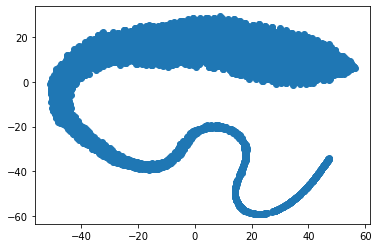

In [22]:
#word2vec
tsne = TSNE(2,50,30)
X_tsne = tsne.fit_transform(X) # apply tsne to the model and plot

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [23]:
tweets_vec = []

for i in range(len(clean_t)):

    word = model[clean_t[i][0]].copy()
    for j in range(1, len(clean_t[i])):
        word += model[clean_t[i][j]].copy()        
    word /= len(clean_t[i])
    word /= la.norm(word)
    tweets_vec.append(word)

C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


C:\Users\mirei\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass perplexity=50, early_exaggeration=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


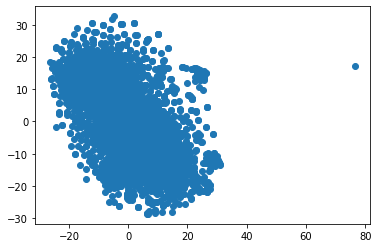

In [24]:
#tweet2vec
tsne = TSNE(2,50,30)
X_tsne = tsne.fit_transform(tweets_vec) # apply tsne to the model and plot

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [25]:
query1 = 'vaccine covid19'
query2 = 'color pandemic'
query3 = 'vaccine pandemic'
query4 = 'color risk'
query5 = 'risk covid19'

queries = [query1, query2, query3, query4, query5]

q_df = pd.DataFrame()
q_df['queries'] = queries

clean_q = q_df['queries'].map(lambda x: build_terms(x))

In [26]:
model_q = Word2Vec(clean_q, min_count=1) # represent all the words (terms) of the query as vectors
words_q = list(model_q.wv.vocab)

In [27]:
queries_vec = []

for i in range(len(clean_q)):

    word = model_q[clean_q[i][0]].copy()
    for j in range(1, len(clean_q[i])):
        word += model_q[clean_q[i][j]].copy()        
    word /= len(clean_q[i])
    word /= la.norm(word)
    queries_vec.append(word)

C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [28]:
# cosine similarity
for i in range(len(queries_vec)):
    
    doc_scores=[[np.dot(tweets_vec[j], queries_vec[i]), j] for j in range(len(tweets_vec))]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    
    print('\nTop 20 cosine scores for the query: ', queries[i])
    for i in range(20):
        print('Score:', doc_scores[i][0], 'id:', doc_scores[i][1])


Top 20 cosine scores for the query:  vaccine covid19
Score: 0.28075558 id: 1585
Score: 0.27955237 id: 563
Score: 0.27911985 id: 1828
Score: 0.27869388 id: 869
Score: 0.27850226 id: 1833
Score: 0.27843925 id: 1097
Score: 0.27841184 id: 1406
Score: 0.27830803 id: 2386
Score: 0.27827406 id: 1270
Score: 0.27824685 id: 2214
Score: 0.27819258 id: 2122
Score: 0.27817845 id: 2383
Score: 0.27812618 id: 1834
Score: 0.27809134 id: 1647
Score: 0.27805582 id: 679
Score: 0.27800158 id: 1519
Score: 0.2778637 id: 2355
Score: 0.27785686 id: 2062
Score: 0.27785543 id: 884
Score: 0.27777636 id: 2349

Top 20 cosine scores for the query:  color pandemic
Score: 0.0882028 id: 649
Score: 0.088071294 id: 992
Score: 0.0878816 id: 1820
Score: 0.0875255 id: 471
Score: 0.087325595 id: 722
Score: 0.08730515 id: 847
Score: 0.08726983 id: 1914
Score: 0.087184854 id: 1014
Score: 0.08718255 id: 243
Score: 0.08710227 id: 1891
Score: 0.08710101 id: 701
Score: 0.08702699 id: 2214
Score: 0.086964116 id: 1162
Score: 0.0869